# Non-working tools

## Snakefood
https://github.com/blais/snakefood

Did not work because:

"Python-3.x is NOT supported, but there have been a few efforts to port to it. I never had time to fully port it; it would require a fair bit of a rewrite to do so IMO."

## PyCallGraph

Couldn't get it to work. Chased down a never-ending rabbithole.

1. Can't find entrypoint / main. Most likely due to the complexity of how the project is run.
2. If we try to help it and give some modules a main(), it then can't figure out the dependencies
3. If we add the dependencies, they haven't been setup properly.
4. Setting them up properly is too hard.

# Initial thoughts

We want to start with some raw metrics like count of files, lines of code.
This is important to give us some context.
Example, if a package consists of 1 file, with 5 lines of code. Then naturally that package will have lower metrics later on, such as cyclomatic dependencies, etc.


Some tools need a __init__ So make a empty .py file in API and Frontend.

# Dependencies setup

In [2]:
import os
import sys
import subprocess

def enforce_numpy_version():
    """
    Ensure that NumPy is installed and is a version below 2.x.
    If a 2.x version (or higher) is found, downgrade to a 1.x version
    and instruct the user to restart the kernel manually if running interactively.
    """
    try:
        import numpy as np
        major_version = int(np.__version__.split('.')[0])
        if major_version >= 2:
            print(f"Detected NumPy version {np.__version__}. Downgrading to numpy<2...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "numpy<2"])
            if "ipykernel" in sys.modules:
                print("Please restart your Jupyter kernel manually after downgrading NumPy.")
                sys.exit(0)
            else:
                print("Restarting the script after downgrading NumPy...")
                os.execv(sys.executable, [sys.executable] + sys.argv)
        else:
            print(f"NumPy version {np.__version__} is compatible (version <2).")
    except ImportError:
        print("NumPy is not installed. Installing numpy<2...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "numpy<2"])
        if "ipykernel" in sys.modules:
            print("Please restart your Jupyter kernel manually after installing NumPy.")
            sys.exit(0)
        else:
            print("Restarting the script after installing NumPy...")
            os.execv(sys.executable, [sys.executable] + sys.argv)

def install_package(package):
    """
    Try to import a package. If it’s not found, install it using pip.
    If pip fails for any reason, catch the exception and print an error message.
    """
    try:
        # Replace dashes with underscores in case the module name differs from the package name.
        __import__(package.replace('-', '_'))
        print(f"{package} is already installed.")
    except ImportError:
        print(f"Installing {package}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        except subprocess.CalledProcessError as e:
            print(f"Failed to install {package}. Error: {e}")

if __name__ == "__main__":
    # Ensure NumPy is compatible before proceeding.
    enforce_numpy_version()
    
    # List of packages to install.
    packages = [
        'radon',
        'matplotlib',
        'pandas',
        'networkx',
        'pydot',
        'squarify',
        'pylint',
        'graphviz',
        'pyan3',
        'prospector'
    ]
    
    for pkg in packages:
        install_package(pkg)
    
    print("All packages have been checked and installed as needed.")


NumPy version 1.26.4 is compatible (version <2).
radon is already installed.
matplotlib is already installed.
pandas is already installed.
networkx is already installed.
pydot is already installed.
squarify is already installed.
pylint is already installed.
graphviz is already installed.
Installing pyan3...
prospector is already installed.
All packages have been checked and installed as needed.


In [3]:
import datetime
import os
import sys
import subprocess
import json
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
import networkx as nx

# Path setup

In [4]:
TOOLS_DIR = os.getcwd()  # Expected: ...\Tools
BASE_DIR = os.path.abspath(os.path.join(TOOLS_DIR, '..'))
DATA_DIR = os.path.join(BASE_DIR, 'Data')

# Our repos to analyse:
API_DIR = os.path.join(DATA_DIR, 'api')
WEB_DIR = os.path.join(DATA_DIR, 'web')

#Tools specific paths:
RADON_OUTPUT_DIR = os.path.join(BASE_DIR, 'output', 'radon')
os.makedirs(RADON_OUTPUT_DIR, exist_ok=True)

# Analyzation project(s) setup

In [5]:
def clone_repo(repo_url, target_dir):
    """
    Clone a git repository from repo_url into target_dir.
    Also create an empty __init__.py file in the repository's root.
    """
    # Ensure the parent directory exists.
    parent_dir = os.path.dirname(target_dir)
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)
        print(f"Created parent directory: {parent_dir}")
    
    # Clone the repository if not already present.
    if not os.path.exists(target_dir):
        subprocess.run(["git", "clone", repo_url, target_dir], check=True)
        print(f"Repository cloned from {repo_url} into {target_dir}")
    else:
        print(f"Repository already exists at {target_dir}")
    
    # Create an empty __init__.py file in the repo root if it doesn't already exist.
    init_file = os.path.join(target_dir, '__init__.py')
    if not os.path.exists(init_file):
        open(init_file, 'w').close()  # This creates an empty file.
        print(f"Empty __init__.py created in {target_dir}")
    else:
        print(f"__init__.py already exists in {target_dir}")

# Clone the zeeguu/api repository.
clone_repo("https://github.com/zeeguu/api", API_DIR)

# Clone the zeeguu/web repository.
clone_repo("https://github.com/zeeguu/web", WEB_DIR)

Repository already exists at c:\Programming\Architecture\ArchitecturalRecovery\Data\api
__init__.py already exists in c:\Programming\Architecture\ArchitecturalRecovery\Data\api
Repository cloned from https://github.com/zeeguu/web into c:\Programming\Architecture\ArchitecturalRecovery\Data\web
Empty __init__.py created in c:\Programming\Architecture\ArchitecturalRecovery\Data\web


# Radon

https://pypi.org/project/radon/

https://radon.readthedocs.io/en/latest/


## Why Radon

Radon is a tool i found great for providing code metrics, especially an overview of some of the common raw metrics like lines of code, number of functions, etc. This will give me a great initial overview, of where the work is placed in the project.


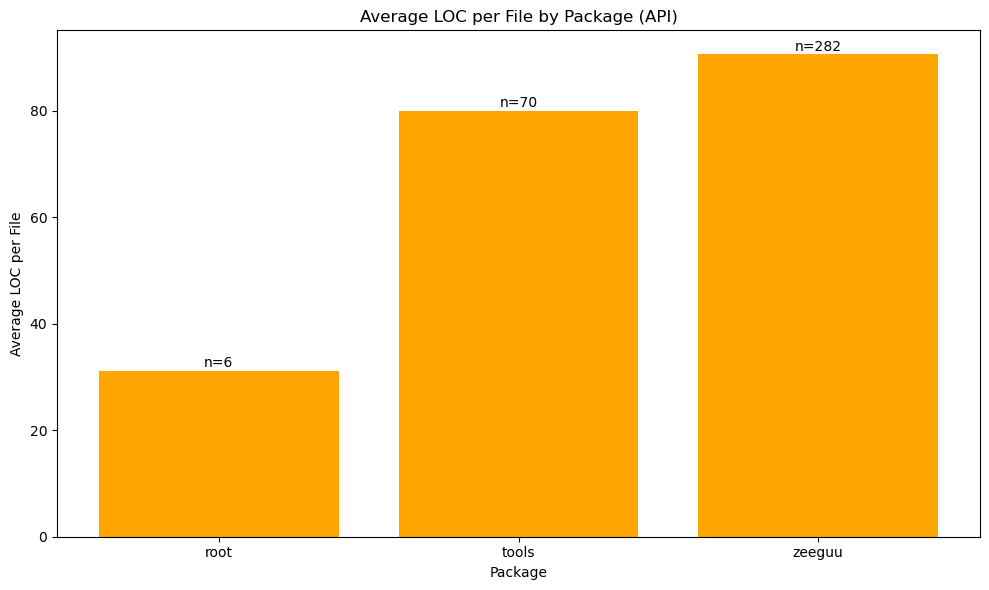

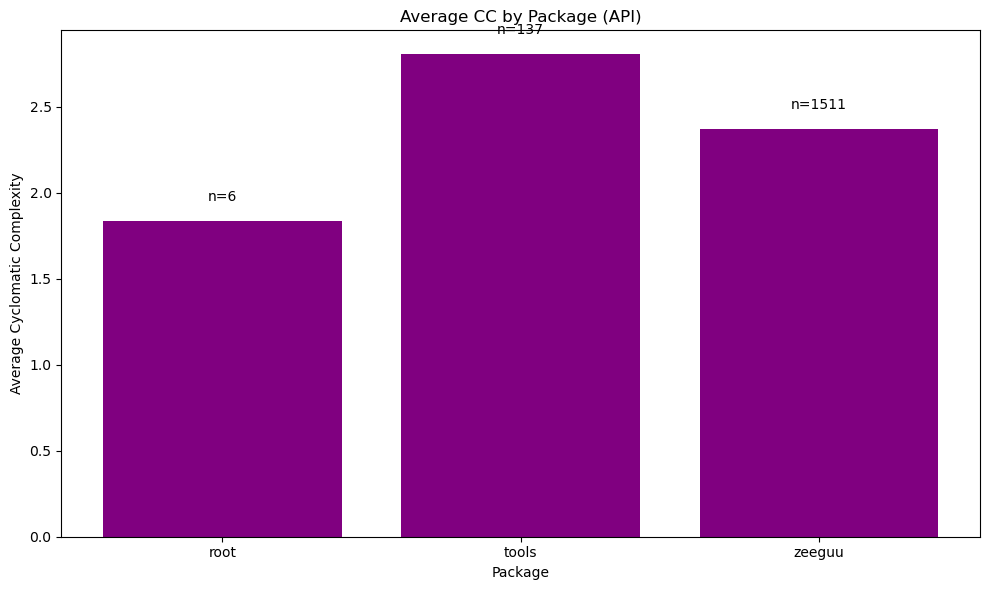

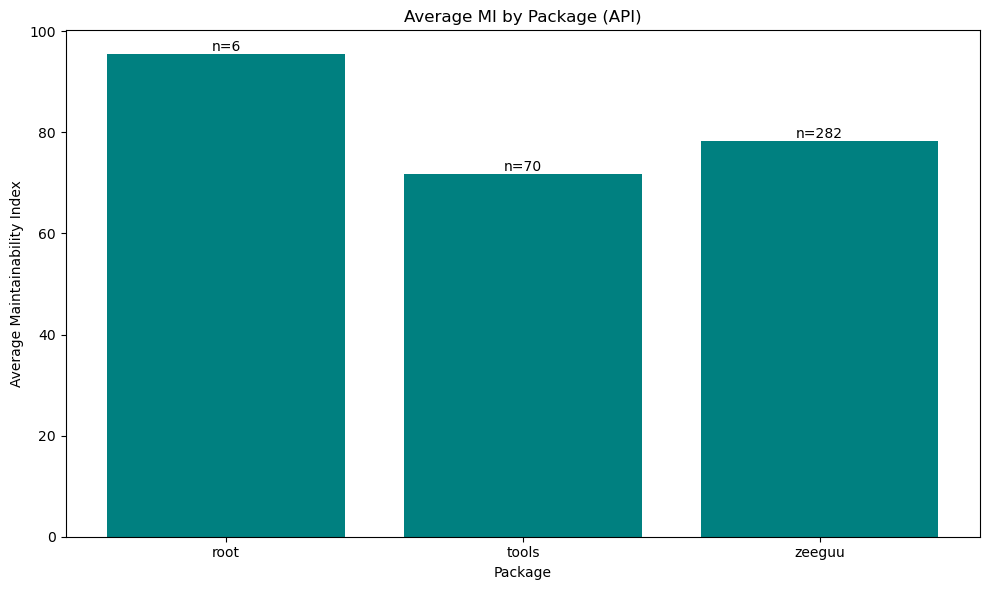

In [8]:
def aggregate_cc_by_package(base_dir):
    cmd = [sys.executable, "-m", "radon", "cc", base_dir, "-j", "-s", "-a"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    pkg_data = defaultdict(list)
    for filepath, funcs in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        pkg = relpath.split(os.sep)[0] if os.sep in relpath else "root"
        for func in funcs:
            pkg_data[pkg].append(func["complexity"])
    return pkg_data

def aggregate_mi_by_package(base_dir):
    cmd = [sys.executable, "-m", "radon", "mi", base_dir, "-j"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    pkg_data = defaultdict(list)
    for filepath, mi_value in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        pkg = relpath.split(os.sep)[0] if os.sep in relpath else "root"
        if isinstance(mi_value, dict):
            pkg_data[pkg].append(mi_value.get("mi", 0))
        else:
            pkg_data[pkg].append(mi_value)
    return pkg_data

def aggregate_raw_by_package(base_dir):
    cmd = [sys.executable, "-m", "radon", "raw", base_dir, "-j", "-s"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    metrics = ["loc", "lloc", "sloc", "comments", "single_comments", "multi", "blank"]
    pkg_totals = defaultdict(lambda: {metric: 0 for metric in metrics})
    pkg_file_count = defaultdict(int)
    for filepath, stats in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        pkg = relpath.split(os.sep)[0] if os.sep in relpath else "root"
        pkg_file_count[pkg] += 1
        for metric in metrics:
            pkg_totals[pkg][metric] += stats.get(metric, 0)
    return pkg_totals, pkg_file_count

# --- Plot Average Cyclomatic Complexity by Package with annotations ---
if __name__ == "__main__":
    
    # --- Plot Average LOC per File by Package with annotations ---
    raw_pkg, pkg_file_count = aggregate_raw_by_package(API_DIR)
    pkg_names_raw = list(raw_pkg.keys())
    avg_loc = [raw_pkg[p]['loc'] / pkg_file_count[p] if pkg_file_count[p] else 0 for p in pkg_names_raw]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(pkg_names_raw, avg_loc, color='orange')
    plt.xlabel("Package")
    plt.ylabel("Average LOC per File")
    plt.title("Average LOC per File by Package (API)")
    for bar, pkg in zip(bars, pkg_names_raw):
        count = pkg_file_count[pkg]
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f"n={count}", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(RADON_OUTPUT_DIR, 'average_loc_by_package.png'))
    plt.show()
    
    # Aggregate cyclomatic complexity data
    cc_pkg = aggregate_cc_by_package(API_DIR)
    pkg_names = list(cc_pkg.keys())
    avg_cc = [sum(cc_pkg[p]) / len(cc_pkg[p]) if cc_pkg[p] else 0 for p in pkg_names]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(pkg_names, avg_cc, color='purple')
    plt.xlabel("Package")
    plt.ylabel("Average Cyclomatic Complexity")
    plt.title("Average CC by Package (API)")
    for bar, pkg in zip(bars, pkg_names):
        count = len(cc_pkg[pkg])
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f"n={count}", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(RADON_OUTPUT_DIR, 'average_cc_by_package.png'))
    plt.show()

    # --- Plot Average Maintainability Index by Package with annotations ---
    mi_pkg = aggregate_mi_by_package(API_DIR)
    pkg_names_mi = list(mi_pkg.keys())
    avg_mi = [sum(mi_pkg[p]) / len(mi_pkg[p]) if mi_pkg[p] else 0 for p in pkg_names_mi]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(pkg_names_mi, avg_mi, color='teal')
    plt.xlabel("Package")
    plt.ylabel("Average Maintainability Index")
    plt.title("Average MI by Package (API)")
    for bar, pkg in zip(bars, pkg_names_mi):
        count = len(mi_pkg[pkg])
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f"n={count}", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(RADON_OUTPUT_DIR, 'average_mi_by_package.png'))
    plt.show()



### Intermediate Analysis

Here we can quickly see that the root only has 6 functions and few lines of code.
Most of the code resides in either /Tools or /Zeeguu, having around 80 lines of code per file, where as Tools consists of 70 functions and zeeguu has the majority of code, containing 282 functions.

Besides Lines of Code and number of functions, Radon will also provide:
* Cyclomatic Complexity, which looks at number of decisions a block of code contains
* Maintainability index. Which is a combination of 4 other metrics https://radon.readthedocs.io/en/latest/intro.html#maintainability-index, being the Halstead index (https://radon.readthedocs.io/en/latest/intro.html#halstead-metrics), which looks at distinct number of operators and operands compared to the total number. As well as the Cyclomatic Complexity, Source Lines of Code (SLOC), and number of comments.

We can see that Tools have a higher CC and lower maintainabiltiy index than Zeeguu.

So now i want to check the subdirectories in /Tools and /Zeeguu

# Architectural-Lens

# GitTruck

# Prospector

# Pyan

# Pyreverse

## Basic project setup

In [7]:
def list_directories(root_dir):
    dirs = []
    for dirpath, dirnames, _ in os.walk(root_dir):
        # Exclude hidden directories
        dirnames[:] = [d for d in dirnames if not d.startswith('.')]
        dirs.append(os.path.relpath(dirpath, root_dir))
    return sorted(dirs)

print("API (Backend) Structure:")
for d in list_directories(os.path.join('..', 'Data', 'api')):
    print(d)

API (Backend) Structure:
.
__pycache__
tools
tools\__pycache__
tools\crawl_summary
tools\migrations
tools\old
tools\old\__pycache__
tools\old\es_v8_migration
tools\old\es_v8_migration\__pycache__
tools\report_generator
tools\sh
tools\sql
zeeguu
zeeguu\__pycache__
zeeguu\api
zeeguu\api\__pycache__
zeeguu\api\endpoints
zeeguu\api\endpoints\__pycache__
zeeguu\api\endpoints\helpers
zeeguu\api\endpoints\teacher_dashboard
zeeguu\api\test
zeeguu\api\test\__pycache__
zeeguu\api\utils
zeeguu\cl
zeeguu\config
zeeguu\config\__pycache__
zeeguu\core
zeeguu\core\__pycache__
zeeguu\core\account_management
zeeguu\core\behavioral_modeling
zeeguu\core\bookmark_quality
zeeguu\core\content_cleaning
zeeguu\core\content_cleaning\__pycache__
zeeguu\core\content_cleaning\data
zeeguu\core\content_quality
zeeguu\core\content_recommender
zeeguu\core\content_retriever
zeeguu\core\content_retriever\__pycache__
zeeguu\core\crowd_translations
zeeguu\core\definition_of_learned
zeeguu\core\diagrams
zeeguu\core\elastic